# Propensity Model Example

Our propensity dataset consists of dummy data, simulating paywall performance for a fictional investing blog. The goal of this exercise is to determine which readers are most ready to subscribe, and use this to inform a new paywall strategy for this investing blog.

In [126]:
library(dplyr)
library(ranger)
library(readr)
library(scales)
library(ggplot2)

## 1. Import Data

In [127]:
data.propensity <- read_csv(file.path('data','propensity_data.csv.gz'))

Parsed with column specification:
cols(
  pageID = col_integer(),
  paywall = col_character(),
  time = col_character(),
  daysSinceFirstSeen = col_integer(),
  section = col_character(),
  visitNum = col_integer(),
  pageNum = col_integer(),
  registered = col_integer(),
  edu = col_integer(),
  mobile = col_integer(),
  mac = col_integer(),
  converted = col_integer()
)


In [128]:
head(data.propensity)

pageID,paywall,time,daysSinceFirstSeen,section,visitNum,pageNum,registered,edu,mobile,mac,converted
35,Open,2018-09-06 02:02:59 UTC,0,Funds,1,1,0,0,1,1,0
50,Locked,2018-09-06 02:04:00 UTC,0,Funds,1,1,0,0,0,0,0
51,Locked,2018-09-06 02:04:01 UTC,0,Funds,1,2,1,0,1,1,0
69,Open,2018-09-06 02:05:40 UTC,0,Funds,1,1,0,0,0,1,0
74,Open,2018-09-06 02:05:59 UTC,0,Funds,1,1,0,0,0,1,0
90,Open,2018-09-06 02:07:49 UTC,0,Funds,1,3,0,0,1,1,0


## 2. Exploratory Analysis

What is the base rate of conversion for locked versus open pages?

In [129]:
data.propensity %>% 
    group_by(paywall) %>%
    summarize(frequency = n(),
              conversion = percent(sum(ifelse(converted == '1', 1, 0) / n())))

paywall,frequency,conversion
Locked,269400,0.188%
Open,320981,0.0604%


How many article views does the blog currently have locked?

In [130]:
data.propensity %>% 
    summarize(percentLocked = percent(sum(ifelse(paywall == 'Locked', 1, 0)) / n()))

percentLocked
45.6%


How does conversion rate differ by visit number?

In [131]:
data.propensity %>% 
    filter(visitNum <= 10) %>%
    group_by(visitNum) %>%
    summarize(frequency = n(),
              conversion = percent(sum(ifelse(converted == '1', 1, 0) / n())))

visitNum,frequency,conversion
1,146289,0.0697%
2,91203,0.124%
3,52343,0.183%
4,36388,0.203%
5,27481,0.138%
6,21546,0.135%
7,17385,0.155%
8,14538,0.144%
9,12287,0.155%
10,10378,0.125%


How do the difference sections perform?

In [132]:
data.propensity %>% 
    group_by(section) %>%
    summarize(frequency = n(),
              conversion = percent(sum(ifelse(converted == '1', 1, 0) / n())))

section,frequency,conversion
Funds,149374,0.128%
Personal Finance,234273,0.0828%
Retirement Planning,32258,0.155%
Stock Tips,174476,0.152%


## 3. Feature Engineering
To include time variables in our model, we're going to use sin and cos function to transform time of day and time of week into numeric variables.

In [133]:
hours <- as.numeric(as.POSIXlt(data.propensity$time, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")$hour) / (24 * 7)
minutes <- as.numeric(as.POSIXlt(data.propensity$time, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")$min) / (24 * 7 * 60)
days <- as.numeric(as.POSIXlt(data.propensity$time, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")$wday) / (7)


In [134]:
data.propensity <- data.propensity %>%
    mutate(converted = factor(converted),
           date = as.Date(time, "%Y-%m-%d"),
           timeOfWeek1 = sin(2 * pi * (hours + minutes + days)),
           timeOfWeek2 = cos(2 * pi * (hours + minutes + days)),
           timeOfDay1 = sin(2 * pi * (hours + minutes) * 7),
           timeOfDay2 = cos(2 * pi * (hours + minutes) * 7))

In [135]:
colnames(data.propensity.train)

[1] "pageID"             "paywall"            "time"              
 [4] "daysSinceFirstSeen" "section"            "visitNum"          
 [7] "pageNum"            "registered"         "edu"               
[10] "mobile"             "mac"                "converted"         
[13] "date"               "timeOfWeek1"        "timeOfWeek2"       
[16] "timeOfDay1"         "timeOfDay2"

In [136]:
variables <- c("paywall",
               "daysSinceFirstSeen",
               "section",
               "visitNum",
               "pageNum",
               "registered",
               "edu",
               "mobile",
               "mac",
               "timeOfWeek1",
               "timeOfWeek2",
               "timeOfDay1",
               "timeOfDay2")

## 4. Build the Model
We're going to split the data by period. We're doing it this way because conversion rates on specific days or times can be highly correlated for all visitors.

In [137]:
data.propensity.train <- data.propensity %>% filter(date < "2018-09-24")
data.propensity.test <- data.propensity %>% filter(date >= "2018-09-24")

In [138]:
model.conversion <- ranger(paste("converted ~", paste(as.list(variables), collapse = " + ")),
                           data = data.propensity.train,
                           write.forest = TRUE,
                           num.trees = 100,
                           min.node.size = 50,
                           probability = TRUE,
                           importance = "impurity")

Growing trees.. Progress: 44%. Estimated remaining time: 39 seconds.
Growing trees.. Progress: 90%. Estimated remaining time: 7 seconds.


In [139]:
importance(model.conversion)

paywall daysSinceFirstSeen            section           visitNum 
         0.9850818         32.0616527          3.2558141         14.9685053 
           pageNum         registered                edu             mobile 
        16.7959444          1.5955463          1.7529646          1.0662332 
               mac        timeOfWeek1        timeOfWeek2         timeOfDay1 
         1.2769199         73.0083676         72.2736580         55.5462602 
        timeOfDay2 
        54.7169916

# 5. Making Predictions
We're going to see how good the calibration is for our model. Ideally, it can identify the probability that specific cohorts will subscribe.

In [140]:
data.propensity.test$predConversion <- predict(model.conversion, data.propensity.test)$predictions[,2]

In [141]:
calibration <- data.propensity.test %>%
    group_by(predConversion = round(predConversion , 4)) %>%
    summarize(count = n(),
              conversions = sum(ifelse(converted == '1', 1, 0)),
             trueConversion = sum(ifelse(converted == '1', 1, 0)) / n())

calibration

predConversion,count,conversions,trueConversion
0.0000,102977,37,0.0003593035
0.0001,25170,23,0.0009137863
0.0002,7341,8,0.0010897698
0.0003,6397,5,0.0007816164
0.0004,4306,3,0.0006967023
0.0005,4675,3,0.0006417112
0.0006,3605,4,0.0011095700
0.0007,3197,6,0.0018767595
0.0008,2760,2,0.0007246377
0.0009,2340,2,0.0008547009


In [142]:
avg.conversion <- mean(ifelse(data.propensity.test$converted == '1', 1, 0))

print(avg.conversion)

[1] 0.001010752


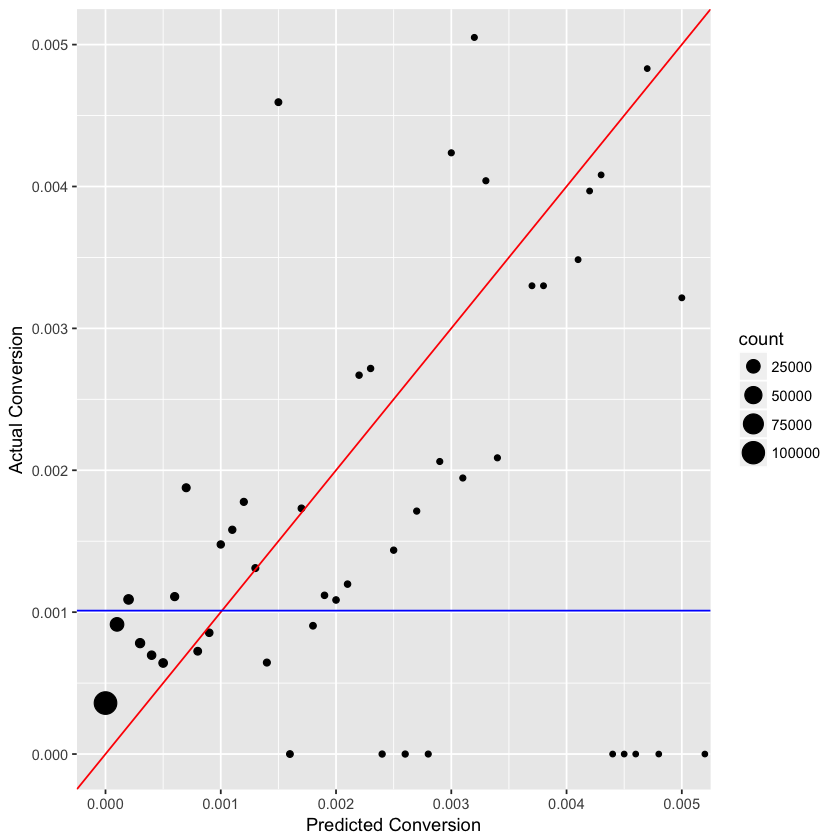

In [143]:
ggplot(calibration,
      aes(x = predConversion,
          y = trueConversion, 
         size = count)) +
    geom_point() +
    coord_cartesian(xlim = c(0, 0.005),
                   ylim = c(0, 0.005)) +
    geom_abline(slope = 1, color = "red") +
    geom_hline(yintercept = avg.conversion, color = "blue") +
    labs(x = "Predicted Conversion", y = "Actual Conversion")

## 6. Assigning Propensity Scores
We're going to assign the impressions with propensity scores, ranging from 1-10. Ideally, a disproportion portion of our sales come from those who fall in the higher cohorts.

In [144]:
propensity <- data.propensity.test %>%
    filter(paywall == "Locked") %>%
    group_by(propensity = 1 + floor(10 * (rank(predConversion)/length(predConversion))-0.00001)) %>%
    summarize(trueConversion = sum(ifelse(converted == '1', 1, 0)) / n(),
              conversions = sum(ifelse(converted == '1', 1, 0)),
              impressions = n())

`geom_smooth()` using method = 'loess'


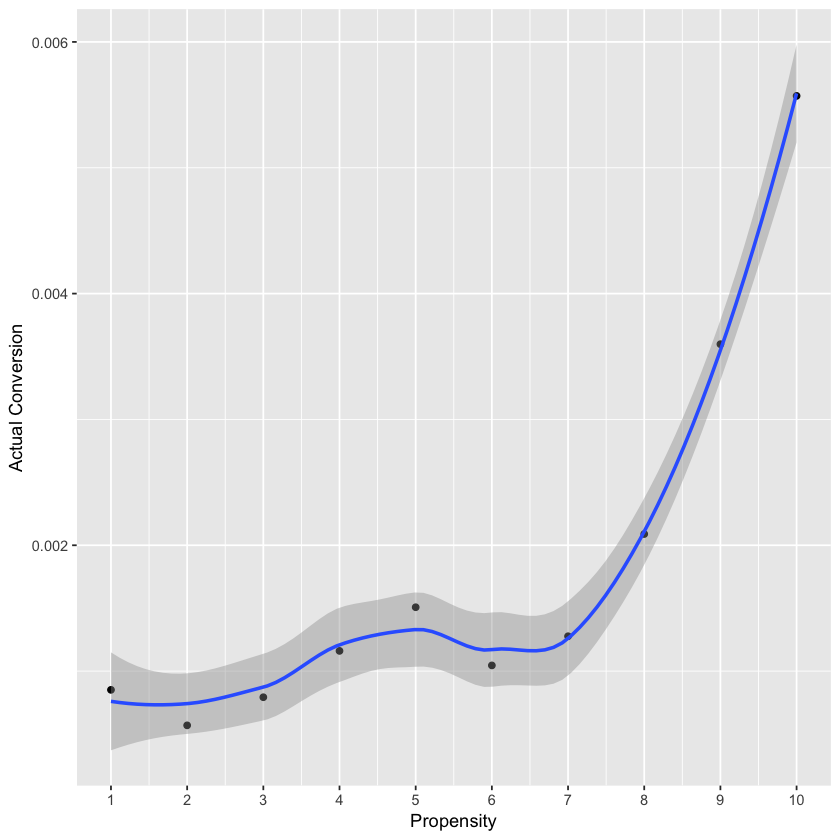

In [145]:
ggplot(propensity,
      aes(x = propensity,
          y = trueConversion)) +
    geom_point() +
    stat_smooth() +
    labs(x = "Propensity", y = "Actual Conversion") +
    scale_x_continuous(breaks = 1:10)

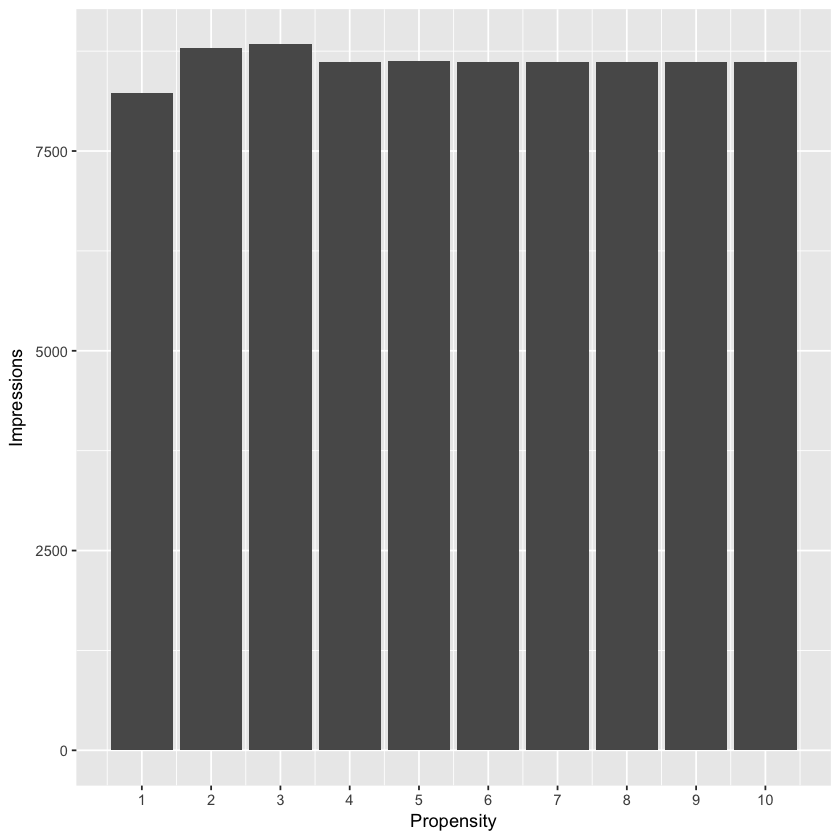

In [146]:
ggplot(propensity,
      aes(x = propensity,
          y = impressions)) +
    geom_bar(stat = "identity") +
    labs(x = "Propensity", y = "Impressions") +
    scale_x_continuous(breaks = 1:10)

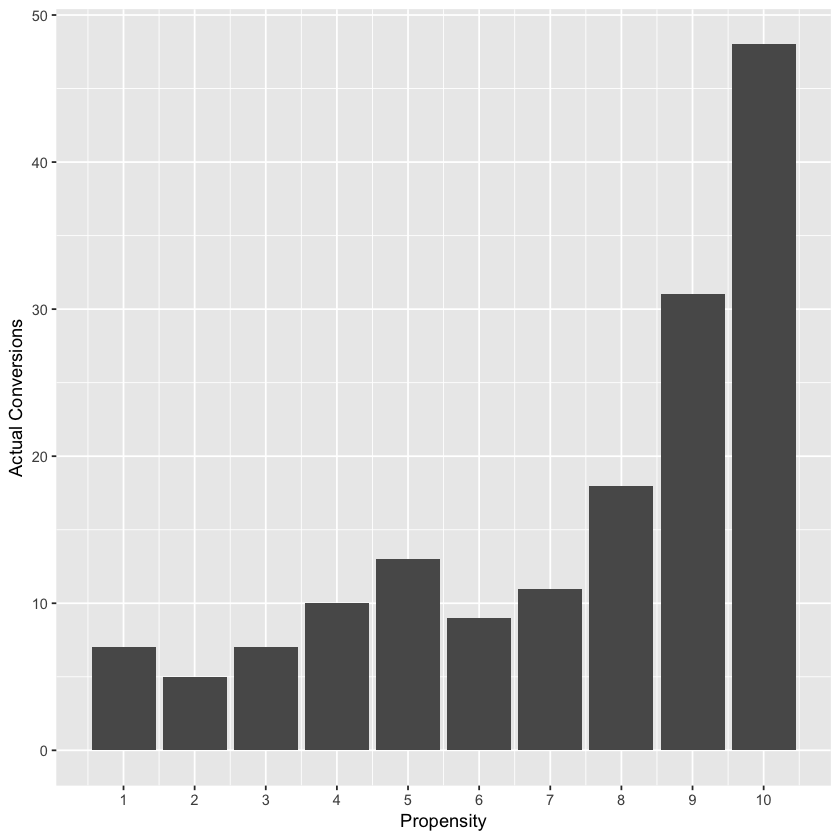

In [147]:
ggplot(propensity,
      aes(x = propensity,
          y = conversions)) +
    geom_bar(stat = "identity") +
    labs(x = "Propensity", y = "Actual Conversions") +
    scale_x_continuous(breaks = 1:10)

### How many sales come from visitors with a propensity score greater than or equal to six (top 50% of visitors)?

In [148]:
conversions.highProp <- propensity %>% 
    filter(propensity >= 6) %>%
    summarize(conversions = sum(conversions))

conversions.highProp

conversions
117


In [149]:
conversions.overall <- propensity %>% 
    summarize(conversions = sum(conversions))

conversions.overall

conversions
159


In [150]:
conversions.highProp / conversions.overall

conversions
0.7358491


### How many sales come from the top 20% of visitors?

In [151]:
conversions.highProp <- propensity %>% 
    filter(propensity >= 9) %>%
    summarize(conversions = sum(conversions))

conversions.highProp

conversions
79


In [152]:
conversions.highProp / conversions.overall

conversions
0.4968553
